In [ ]:
#finetune_roberta.py

In [1]:
import pandas as pd
json_file_path = './merged_int_SRS_df_op1_2nd_1004_Nov04F2.json'
merged_int_SRS_df = pd.read_json(json_file_path, orient='records', lines=True)

In [ ]:
# option1 : 2nd High Vs ASD

In [2]:
# Define label mapping
label_mapping = {'TD': 0, 'High': 1, 'ASD': 2}

# Preprocess the dataset 4 tasks #'Played catch_new', 'Fed baby doll_new','Reacted to snack_new', 
def preprocess_function_2(row):
    # task_results = f"1. Name calling response: {row['Responded to name_new2']} 2. Mimicked actions: {row['Mimicked actions1_new2'] + row['Mimicked actions2_new2']} 4. Played catch: {row['Played catch_new2']} 5. Fed baby doll: {row['Fed baby doll_new2']} 6. Reacted to snack: {row['Reacted to snack_new2']}"
    task_results = f" {row['Responded to name_new2']} ,{row['Mimicked actions1_new2'] + row['Mimicked actions2_new2']} ,{row['Played catch_new2']} ,{row['Fed baby doll_new2']} ,{row['Reacted to snack_new2']}"
    input_text = f"Task Results: {task_results} Combined: {row['combined']}"
    label = label_mapping[row['Class_ex']]
    return {"SubjectId": row['SubjectId'], "text": input_text, "label": label}

preprocessed_2 = merged_int_SRS_df.apply(preprocess_function_2, axis=1)
preprocessed_df2 = pd.DataFrame(preprocessed_2.tolist())

# Check if the 'SubjectId', 'text', and 'label' columns are created correctly
# print(preprocessed_df[['SubjectId','text', 'label']].head())
print(preprocessed_df2[['SubjectId','text', 'label']].head())

    SubjectId                                               text  label
0  1023032801  Task Results:  Success of Responded to name ,S...      0
1  1023040831  Task Results:  Success of Responded to name ,F...      2
2  1023041001  Task Results:  Success of Responded to name ,S...      2
3  1023041311  Task Results:  Success of Responded to name ,S...      0
4  1023041701  Task Results:  Success of Responded to name ,F...      2


In [3]:

df_sF= preprocessed_df2[['SubjectId','text', 'label']]
df_sF.columns=['SubjectId','text','Class']

In [4]:
df_sF['label'] = df_sF['Class']
df_sF.label.value_counts()

label
2    353
0    188
1    162
Name: count, dtype: int64

In [5]:
ASD_mapping2 = {
    # 0: 0, # TD
    1: 0, # High risk of ASD
    2: 1, # ASD
}

# Select only rows with 'High' and 'ASD'
df_sF2 = df_sF[df_sF['Class'].isin([1, 2])]
# df_sF2 = df_sF

df_sF2['label'] = df_sF2['Class'].replace(ASD_mapping2)
df_sF2.label.value_counts()
df_m2=df_sF2

/tmp/ipykernel_8139/2707431814.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sF2['label'] = df_sF2['Class'].replace(ASD_mapping2)


In [6]:
df_m2['label'].value_counts()

label
1    353
0    162
Name: count, dtype: int64

In [7]:
df_m2.to_json('./df_m2_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

In [ ]:
# import pandas as pd
# # JSON 파일을 데이터프레임으로 다시 불러오기 :./df_m2_5tasks_SRS_1004_Oct23_nov01.csv
# df_m2 = pd.read_json('./df_m2_5tasks_SRS_1004_Jan07F2.json'', orient='records', lines=True)


In [2]:
import pandas as pd
import numpy as np

In [3]:
import torch

if torch.cuda.is_available(): 
    print("GPU is available")

GPU is available


In [4]:
import random
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [10]:
from sklearn.model_selection import StratifiedGroupKFold

# Initialize StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5)

# Get the indices for training and test sets
train_idx, temp_idx = next(sgkf.split(df_m2, df_m2['label'], groups=df_m2['SubjectId']))

# Create the training and test sets
train = df_m2.iloc[train_idx]
temp = df_m2.iloc[temp_idx]

# Repeat for the validation set
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)
# Get the indices for validation and test sets
for val_idx, test_idx in sgkf.split(temp, temp['label'], groups=temp['SubjectId']):
    break

# Create the validation and test sets
val = temp.iloc[val_idx]
test = temp.iloc[test_idx]

# Verify the label distribution
print("\nLabel distribution in Train set:")
print(train['label'].value_counts(normalize=True))
print("\nLabel distribution in Validation set:")
print(val['label'].value_counts(normalize=True))
print("\nLabel distribution in Test set:")
print(test['label'].value_counts(normalize=True))


Label distribution in Train set:
label
1    0.686893
0    0.313107
Name: proportion, dtype: float64

Label distribution in Validation set:
label
1    0.634615
0    0.365385
Name: proportion, dtype: float64

Label distribution in Test set:
label
1    0.72549
0    0.27451
Name: proportion, dtype: float64


In [11]:
# after the chekin g the other lab part 2 below 
print(train['label'].value_counts())
print(val['label'].value_counts())
print(test['label'].value_counts())

label
1    283
0    129
Name: count, dtype: int64
label
1    33
0    19
Name: count, dtype: int64
label
1    37
0    14
Name: count, dtype: int64


In [12]:

train.to_json('./train_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
val.to_json('./val_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
test.to_json('./test_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
# train.to_json('./train_5tasks_SRS_20250103_labelsplit_0107.son', orient='records', lines=True)
# val.to_json('./val_5tasks_SRS_20250103_labelsplit_0107.json', orient='records', lines=True)
# test.to_json('./test_5tasks_SRS_20250103_labelsplit_0107.json', orient='records', lines=True)

In [ ]:
# compared and distributed

In [5]:
# df_m2.to_json('./df_m2_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

# df_m2.to_json('./df_m2_5tasks_SRS_20250102_Jan07F2.json', orient='records', lines=True)
path = '/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Git/'
df_m2_new = pd.read_json(f'{path}df_m2_5tasks_SRS_20250102_Jan07F2.json', orient='records', lines=True)
df_m2_old = pd.read_json(f'{path}df_m2_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

df_m2_added = df_m2_new[~df_m2_new['SubjectId'].isin(df_m2_old['SubjectId'])]
df_m2_del = df_m2_old[~df_m2_old['SubjectId'].isin(df_m2_new['SubjectId'])]


print(f"del: {len(df_m2_del)}")
print(f"added: {len(df_m2_added)}")
print(f"old: {len(df_m2_old)}")
print(f"new: {len(df_m2_new)}")

del: 2
added: 57
old: 515
new: 571


In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold

# 경로 설정
path = '/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Git/'

# 데이터 불러오기
df_m2_new = pd.read_json(f'{path}df_m2_5tasks_SRS_20250102_Jan07F2.json', orient='records', lines=True)
df_m2_old = pd.read_json(f'{path}df_m2_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

# 추가된 데이터와 삭제된 데이터 추출
df_m2_added = df_m2_new[~df_m2_new['SubjectId'].isin(df_m2_old['SubjectId'])]
df_m2_del = df_m2_old[~df_m2_old['SubjectId'].isin(df_m2_new['SubjectId'])]

# 기존 데이터 불러오기
train_old = pd.read_json(f'{path}train_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
val_old = pd.read_json(f'{path}val_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
test_old = pd.read_json(f'{path}test_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

# df_m2_del에 해당하는 데이터를 삭제
train_old = train_old[~train_old['SubjectId'].isin(df_m2_del['SubjectId'])]
val_old = val_old[~val_old['SubjectId'].isin(df_m2_del['SubjectId'])]
test_old = test_old[~test_old['SubjectId'].isin(df_m2_del['SubjectId'])]

# df_m2_added 데이터를 8:1:1 비율로 나누기
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
train_idx, val_idx, test_idx = None, None, None

for fold, (train_val_idx, test_idx) in enumerate(sgkf.split(df_m2_added, df_m2_added['label'], groups=df_m2_added['SubjectId'])):
    if fold == 0:
        train_idx, temp_idx = train_val_idx, test_idx
        break

sgkf = StratifiedGroupKFold(n_splits=9, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df_m2_added.iloc[train_idx], df_m2_added.iloc[train_idx]['label'], groups=df_m2_added.iloc[train_idx]['SubjectId'])):
    if fold == 0:
        break

train_added = df_m2_added.iloc[train_idx]
val_added = df_m2_added.iloc[val_idx]
test_added = df_m2_added.iloc[test_idx]

# 기존 데이터에 추가된 데이터를 합치기
train = pd.concat([train_old, train_added])
val = pd.concat([val_old, val_added])
test = pd.concat([test_old, test_added])

# 결과 출력
print(f"Train Data Length: {len(train)}")
print(f"Val Data Length: {len(val)}")
print(f"Test Data Length: {len(test)}")

# 데이터를 JSON 파일로 저장
train.to_json(f'{path}train_5tasks_SRS_updated.json', orient='records', lines=True)
val.to_json(f'{path}val_5tasks_SRS_updated.json', orient='records', lines=True)
test.to_json(f'{path}test_5tasks_SRS_updated.json', orient='records', lines=True)

Train Data Length: 455
Val Data Length: 58
Test Data Length: 57


In [9]:
# after the chekin g the other lab part 2 below 
print(train['label'].value_counts())
print(val['label'].value_counts())
print(test['label'].value_counts())

label
1    299
0    156
Name: count, dtype: int64
label
1    36
0    22
Name: count, dtype: int64
label
1    39
0    18
Name: count, dtype: int64


In [10]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
from transformers.modeling_outputs import SequenceClassifierOutput
import os
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from typing import List, Optional, Tuple, Union
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import seaborn as sns

# --- Global Settings ---
RANDOM_SEED = 42  # Set your desired seed
MODEL_NAME = 'roberta-large'
NUM_LABELS = 2
# DATA_PATH = ''  # Your data path
SAVE_DIR = f"../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_20250102_seed_{RANDOM_SEED}_Jan09F"  

import random
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
set_seed(RANDOM_SEED)
# --- Helper Functions ---

# def set_seed(seed):
#     """Sets the seed for reproducibility."""
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)  # For multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)
#     random.seed(seed)

# --- Data Loading and Preprocessing ---

# def load_and_preprocess_data(df_m2):
#     """Loads, preprocesses, and splits the data into train, val, and test sets."""
#     # df_sF = pd.read_json(f'{data_path}merged_int_SRS_df_op1_2nd_1004_Nov04.json', orient='records', lines=True)
#     # #df_sF = pd.read_json(f'{data_path}merged_int_SRS_df_op1_2nd_1004_Nov04.json', orient='records', lines=True) # merged_int_SRS_df_op1_2nd_1004_Nov04.json

#     # # Filter and map labels (if needed)
#     # # Modify this part if you need different label filtering/mapping
#     # df_sF2 = df_sF[df_sF['Class'].isin([1, 2])]
#     # df_sF2['label'] = df_sF2['Class'].replace({1: 0, 2: 1}) 
#     # df_m2 = df_sF2

#     # Split data using StratifiedGroupKFold
#     sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

#     # Get the indices for training and the rest
#     train_idx, temp_idx = next(sgkf.split(df_m2, df_m2['label'], groups=df_m2['SubjectId']))
#     train = df_m2.iloc[train_idx]
#     temp = df_m2.iloc[temp_idx]

#     # Split the rest into validation and test sets
#     sgkf_val_test = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)
#     val_idx, test_idx = next(sgkf_val_test.split(temp, temp['label'], groups=temp['SubjectId']))
#     val = temp.iloc[val_idx]
#     test = temp.iloc[test_idx]
    
#     return train, val, test

# --- Tokenization and Dataset Creation ---

def tokenize_and_pad(tokenizer, dataset, max_length=567):
    """Tokenizes and pads the input text."""
    return tokenizer(
        dataset['text'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length
    )

class ASD_Dataset(Dataset):
    """Custom Dataset class for ASD classification."""
    def __init__(self, encodings, labels, subject_ids):
        self.encodings = encodings
        self.labels = labels
        self.subject_ids = subject_ids

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['SubjectId'] = self.subject_ids[idx]
        return item

    def __len__(self):
        return len(self.labels)

    @property
    def column_names(self):
        return list(self.encodings.keys()) + ['labels', 'SubjectId']

# --- Model and Training Setup ---

def setup_model_and_training_args():
    """Sets up the RoBERTa model, tokenizer, and training arguments."""
    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

    training_args = TrainingArguments(
        output_dir='./output',
        num_train_epochs=10,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=0,
        weight_decay=1e-8,
        logging_dir='./Roberta/log',
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        gradient_accumulation_steps=4,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
    )

    return model, tokenizer, training_args

# --- Evaluation Metrics ---

def compute_metrics_binary(p):
    """Computes evaluation metrics for binary classification."""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average='binary')
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    auroc = roc_auc_score(labels, predictions)
    avgprc = average_precision_score(labels, predictions)

    return {
        "acc": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auroc": auroc,
        "avgprc": avgprc
    }



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

  0%|          | 0/140 [00:00<?, ?it/s]

{'loss': 0.6897, 'grad_norm': 4.005770683288574, 'learning_rate': 1.8571428571428575e-05, 'epoch': 0.7}


  0%|          | 0/8 [00:00<?, ?it/s]

Checkpoint destination directory ./output/checkpoint-14 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6570467352867126, 'eval_acc': 0.6206896551724138, 'eval_f1': 0.7659574468085106, 'eval_precision': 0.6206896551724138, 'eval_recall': 1.0, 'eval_auroc': 0.5, 'eval_avgprc': 0.6206896551724138, 'eval_runtime': 1.4872, 'eval_samples_per_second': 38.998, 'eval_steps_per_second': 5.379, 'epoch': 0.98}
{'loss': 0.6092, 'grad_norm': 10.347908973693848, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.4}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5385600924491882, 'eval_acc': 0.7413793103448276, 'eval_f1': 0.810126582278481, 'eval_precision': 0.7441860465116279, 'eval_recall': 0.8888888888888888, 'eval_auroc': 0.6944444444444444, 'eval_avgprc': 0.7304642252517152, 'eval_runtime': 1.4667, 'eval_samples_per_second': 39.545, 'eval_steps_per_second': 5.454, 'epoch': 1.96}
{'loss': 0.5351, 'grad_norm': 59.68698501586914, 'learning_rate': 1.5714285714285715e-05, 'epoch': 2.11}
{'loss': 0.49, 'grad_norm': 8.831342697143555, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6051468849182129, 'eval_acc': 0.7068965517241379, 'eval_f1': 0.7792207792207793, 'eval_precision': 0.7317073170731707, 'eval_recall': 0.8333333333333334, 'eval_auroc': 0.6666666666666667, 'eval_avgprc': 0.7132043734230445, 'eval_runtime': 1.4954, 'eval_samples_per_second': 38.785, 'eval_steps_per_second': 5.35, 'epoch': 2.95}
{'loss': 0.531, 'grad_norm': 12.639811515808105, 'learning_rate': 1.2857142857142859e-05, 'epoch': 3.51}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5424844622612, 'eval_acc': 0.7413793103448276, 'eval_f1': 0.810126582278481, 'eval_precision': 0.7441860465116279, 'eval_recall': 0.8888888888888888, 'eval_auroc': 0.6944444444444444, 'eval_avgprc': 0.7304642252517152, 'eval_runtime': 1.5371, 'eval_samples_per_second': 37.734, 'eval_steps_per_second': 5.205, 'epoch': 4.0}
{'loss': 0.4811, 'grad_norm': 5.935698509216309, 'learning_rate': 1.1428571428571429e-05, 'epoch': 4.21}
{'loss': 0.4996, 'grad_norm': 11.987719535827637, 'learning_rate': 1e-05, 'epoch': 4.91}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5921149849891663, 'eval_acc': 0.7413793103448276, 'eval_f1': 0.8148148148148148, 'eval_precision': 0.7333333333333333, 'eval_recall': 0.9166666666666666, 'eval_auroc': 0.6856060606060606, 'eval_avgprc': 0.7239463601532566, 'eval_runtime': 1.492, 'eval_samples_per_second': 38.873, 'eval_steps_per_second': 5.362, 'epoch': 4.98}
{'loss': 0.4433, 'grad_norm': 4.099149227142334, 'learning_rate': 8.571428571428571e-06, 'epoch': 5.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6687108874320984, 'eval_acc': 0.7241379310344828, 'eval_f1': 0.8048780487804879, 'eval_precision': 0.717391304347826, 'eval_recall': 0.9166666666666666, 'eval_auroc': 0.6628787878787878, 'eval_avgprc': 0.7093328335832083, 'eval_runtime': 1.4845, 'eval_samples_per_second': 39.07, 'eval_steps_per_second': 5.389, 'epoch': 5.96}
{'loss': 0.446, 'grad_norm': 5.262945652008057, 'learning_rate': 7.1428571428571436e-06, 'epoch': 6.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.586999773979187, 'eval_acc': 0.7758620689655172, 'eval_f1': 0.8354430379746836, 'eval_precision': 0.7674418604651163, 'eval_recall': 0.9166666666666666, 'eval_auroc': 0.731060606060606, 'eval_avgprc': 0.7552125100240578, 'eval_runtime': 1.4887, 'eval_samples_per_second': 38.96, 'eval_steps_per_second': 5.374, 'epoch': 6.95}
{'loss': 0.4139, 'grad_norm': 10.26574420928955, 'learning_rate': 5.7142857142857145e-06, 'epoch': 7.02}
{'loss': 0.3746, 'grad_norm': 4.093924522399902, 'learning_rate': 4.2857142857142855e-06, 'epoch': 7.72}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5246720910072327, 'eval_acc': 0.7413793103448276, 'eval_f1': 0.7887323943661971, 'eval_precision': 0.8, 'eval_recall': 0.7777777777777778, 'eval_auroc': 0.7297979797979798, 'eval_avgprc': 0.7601532567049809, 'eval_runtime': 1.4969, 'eval_samples_per_second': 38.745, 'eval_steps_per_second': 5.344, 'epoch': 8.0}
{'loss': 0.4121, 'grad_norm': 13.179999351501465, 'learning_rate': 2.8571428571428573e-06, 'epoch': 8.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.528542697429657, 'eval_acc': 0.7413793103448276, 'eval_f1': 0.8051948051948052, 'eval_precision': 0.7560975609756098, 'eval_recall': 0.8611111111111112, 'eval_auroc': 0.7032828282828283, 'eval_avgprc': 0.7372909073918326, 'eval_runtime': 1.5214, 'eval_samples_per_second': 38.123, 'eval_steps_per_second': 5.258, 'epoch': 8.98}
{'loss': 0.3855, 'grad_norm': 7.925923824310303, 'learning_rate': 1.4285714285714286e-06, 'epoch': 9.12}
{'loss': 0.3647, 'grad_norm': 3.942628860473633, 'learning_rate': 0.0, 'epoch': 9.82}


  0%|          | 0/8 [00:00<?, ?it/s]

Checkpoint destination directory ./output/checkpoint-140 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5281287431716919, 'eval_acc': 0.7586206896551724, 'eval_f1': 0.8157894736842105, 'eval_precision': 0.775, 'eval_recall': 0.8611111111111112, 'eval_auroc': 0.726010101010101, 'eval_avgprc': 0.7535680076628353, 'eval_runtime': 1.4728, 'eval_samples_per_second': 39.38, 'eval_steps_per_second': 5.432, 'epoch': 9.82}
{'train_runtime': 919.3847, 'train_samples_per_second': 4.949, 'train_steps_per_second': 0.152, 'train_loss': 0.4768392034939357, 'epoch': 9.82}


  0%|          | 0/8 [00:00<?, ?it/s]

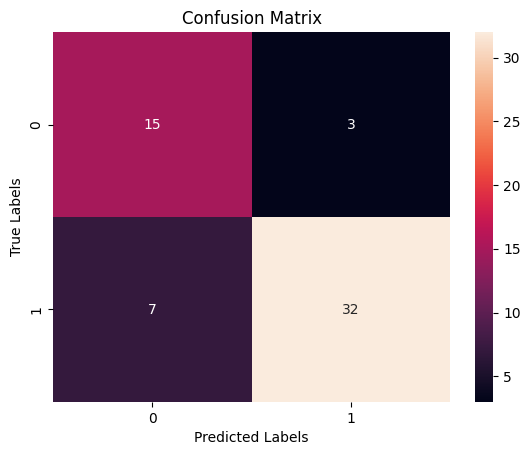

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.91      0.82      0.86        39

    accuracy                           0.82        57
   macro avg       0.80      0.83      0.81        57
weighted avg       0.84      0.82      0.83        57



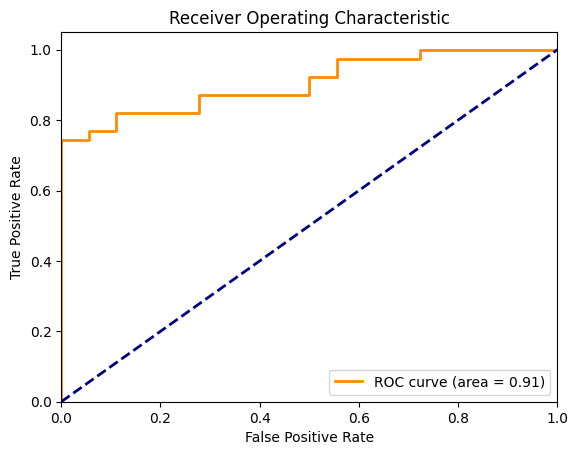

    SubjectId                                               text  True_Labels  \
0  1023041001  Task Results:  Success of Responded to name ,S...            1   
1  1023052034  Task Results:  Success of Responded to name ,S...            1   
2  1023053011  Task Results:  Failure of  ,Failure of  ,Succe...            1   
3  1023061461  Task Results:  Success of Responded to name ,S...            1   
4  1023080172  Task Results:  Failure of  ,Success of Mimicke...            1   

   Predictions              Probabilities  
0            1   [0.08660594, 0.91339403]  
1            1    [0.21910988, 0.7808901]  
2            0   [0.84990567, 0.15009439]  
3            1  [0.013302803, 0.98669714]  
4            1   [0.012546764, 0.9874533]  


In [11]:
# --- Main Script ---

if __name__ == "__main__":
    # set_seed(RANDOM_SEED)

    # # Load and preprocess data
    # train, val, test = load_and_preprocess_data(df_m2)

    # Setup model, tokenizer, and training arguments
    model, tokenizer, training_args = setup_model_and_training_args()

    # Tokenize data
    train_encodings = tokenize_and_pad(tokenizer, train)
    val_encodings = tokenize_and_pad(tokenizer, val)
    test_encodings = tokenize_and_pad(tokenizer, test)

    # Extract SubjectIds
    train_subject_ids = train['SubjectId'].tolist()
    val_subject_ids = val['SubjectId'].tolist()
    test_subject_ids = test['SubjectId'].tolist()

    # Create datasets
    train_dataset = ASD_Dataset(train_encodings, train['label'].tolist(), train_subject_ids)
    val_dataset = ASD_Dataset(val_encodings, val['label'].tolist(), val_subject_ids)
    test_dataset = ASD_Dataset(test_encodings, test['label'].tolist(), test_subject_ids)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary
    )

    # Train the model
    trainer.train()

    # Save the model and tokenizer
    trainer.save_model(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)

    # Generate predictions on the test set
    predictions_output = trainer.predict(test_dataset)
    predictions = np.argmax(predictions_output.predictions, axis=-1)
    probabilities = softmax(predictions_output.predictions, axis=-1)
    true_labels = predictions_output.label_ids

    # Create a DataFrame for results
    df_results = pd.DataFrame({
        'True_Labels': true_labels,
        'Predictions': predictions,
        'Probabilities': list(probabilities)
    })


    # --- Evaluation and Visualization ---

    # Confusion Matrix
    conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(df_results['True_Labels'], df_results['Predictions'])
    print("Classification Report:\n", class_report)

    # ROC Curve
    y_true = np.array(df_results['True_Labels'])  # Corrected line: Added .array
    y_proba = np.array([proba[1] for proba in df_results['Probabilities']])
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Create a detailed DataFrame with predictions, probabilities, and text
    test_data = [test_dataset[i] for i in range(len(test_dataset))]
    df_test_data = pd.DataFrame(test_data)
    df_test_data['True_Labels'] = true_labels
    df_test_data['Predictions'] = predictions
    df_test_data['Probabilities'] = list(probabilities)

    # Add the original text to the DataFrame
    df_test_data['text'] = test['text'].tolist()

    # Example: Display a few rows with text, predictions, and probabilities
    print(df_test_data[['SubjectId','text', 'True_Labels', 'Predictions', 'Probabilities']].head())

    # (Optional) Save the detailed DataFrame to a CSV
    # df_test_data.to_csv('test_predictions_with_details.csv', index=False)

    # (Optional) Print the training logs
    # print(trainer.state.log_history)

In [12]:
# Generate predictions for train, validation, and test sets
fold_num = 42 # 100 # 2021 # 100, 42 # 12345 , 7, 2021 #42,

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset

# ... (your existing code) ...

# Step 2: Tokenize and Prepare Data
def tokenize_and_pad(dataset):
    return tokenizer(
        dataset['text'].tolist(),  # Use 'Combined_Text' instead of 'text'
        truncation=True,
        padding=True,
        max_length=567  # Set maximum length to 494 tokens
    )

# Tokenize the datasets
train_encodings = tokenize_and_pad(train)
val_encodings = tokenize_and_pad(val)
test_encodings = tokenize_and_pad(test)

# Extract SubjectIds and Class labels before tokenization
train_subject_ids = train['SubjectId'].tolist()
val_subject_ids = val['SubjectId'].tolist()
test_subject_ids = test['SubjectId'].tolist()
train_classes = train['Class'].tolist()  # Extract Class labels
val_classes = val['Class'].tolist()
test_classes = test['Class'].tolist()

# Define the ASD_Dataset class
class ASD_Dataset(Dataset):
    def __init__(self, encodings, labels, subject_ids, classes):  # Add classes parameter
        self.encodings = encodings
        self.labels = labels
        self.subject_ids = subject_ids
        self.classes = classes  # Store Class labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        item['SubjectId'] = self.subject_ids[idx]
        item['Class'] = self.classes[idx]  # Include Class label in the item
        return item

    def __len__(self):
        return len(self.labels)

    @property
    def column_names(self):
        return list(self.encodings.keys()) + ['labels', 'SubjectId', 'Class']  # Add 'Class'


# Create datasets (include Class labels)
train_dataset = ASD_Dataset(train_encodings, train['label'].tolist(), train_subject_ids, train_classes)
val_dataset = ASD_Dataset(val_encodings, val['label'].tolist(), val_subject_ids, val_classes)
test_dataset = ASD_Dataset(test_encodings, test['label'].tolist(), test_subject_ids, test_classes)

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset

# ... (your existing code for tokenize_and_pad, ASD_Dataset, 
#      train_dataset, val_dataset, test_dataset) ...

def evaluate_predictions(trainer, current_dataset, subject_ids, fold_num, dataset_name,split_num):
    """
    Evaluates model predictions and generates performance metrics.

    Args:
      trainer: The Hugging Face Trainer object.
      current_dataset: The dataset to evaluate (train, val, or test).
      subject_ids: List of subject IDs corresponding to the dataset.
      fold_num: The current fold number in cross-validation.
      dataset_name: Name of the dataset (e.g., 'train', 'val', 'test').

    Returns:
      A DataFrame containing the results (subject IDs, true labels, predictions, 
      probabilities, Class).
    """

    # Get predictions
    predictions_output = trainer.predict(current_dataset)

    # Extract predictions and probabilities
    predictions = np.argmax(predictions_output.predictions, axis=-1)
    probabilities = softmax(predictions_output.predictions, axis=-1)
    true_labels = predictions_output.label_ids

    # Get the class labels from the dataset
    original_classes = [item['Class'] for item in current_dataset]

    # Create a DataFrame from the data
    df_results = pd.DataFrame({
        'SubjectId': subject_ids,
        'True_Labels': true_labels,
        'Predictions': predictions,
        'Probabilities': list(probabilities),
        'Class': original_classes,  # Add the 'Class' column
    })

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])
    class_report = classification_report(df_results['True_Labels'], df_results['Predictions'])

    print(f"Fold {fold_num} - {dataset_name} - Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.title(f"Fold {fold_num} - {dataset_name} - Confusion Matrix")
    plt.show()

    # ROC curve and AUROC
    y_true = np.array(df_results['True_Labels'])
    y_proba = np.array([proba[1] for proba in df_results['Probabilities']])  # Probabilities for class 1
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2,
 linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Fold {fold_num} - {dataset_name} - Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

    # Save results to CSV
    df_results.to_csv(f'./Split{split_num}_option1_2nd_fold{fold_num}_{dataset_name}_predictions.csv', index=False)

    return df_results




  0%|          | 0/57 [00:00<?, ?it/s]

Fold 42 - train - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       156
           1       0.93      0.77      0.84       299

    accuracy                           0.81       455
   macro avg       0.80      0.83      0.81       455
weighted avg       0.84      0.81      0.82       455



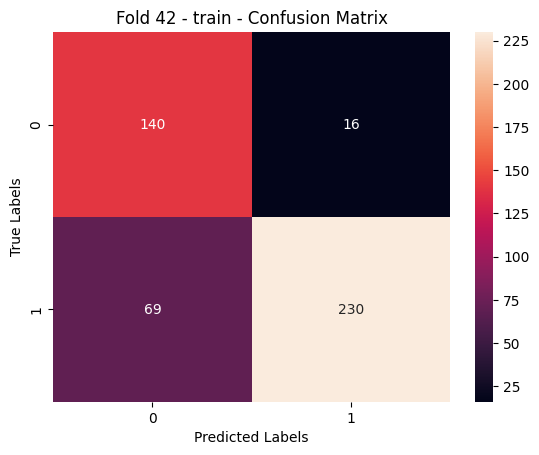

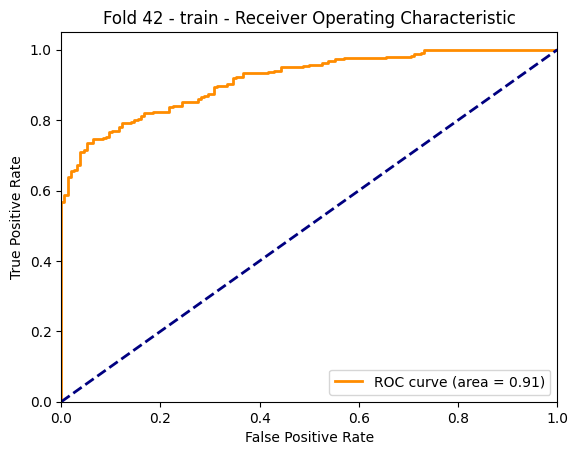

In [16]:

# Evaluate on train dataset
df_results_train = evaluate_predictions(trainer, train_dataset, train_subject_ids, fold_num, "train",80_1010)

  0%|          | 0/8 [00:00<?, ?it/s]

Fold 42 - val - Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        22
           1       0.80      0.78      0.79        36

    accuracy                           0.74        58
   macro avg       0.73      0.73      0.73        58
weighted avg       0.74      0.74      0.74        58



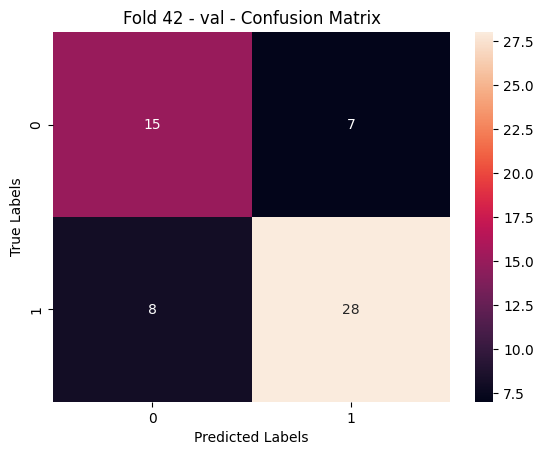

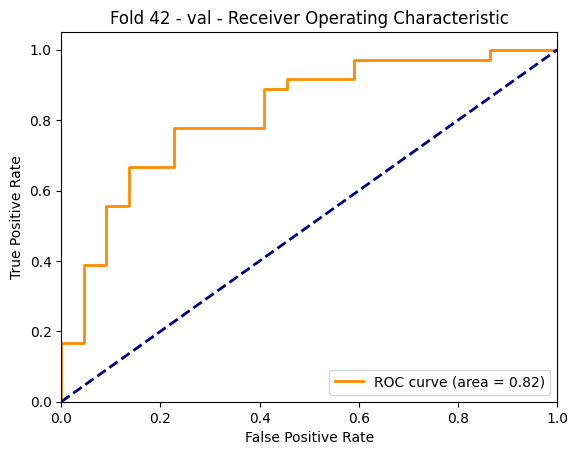

In [17]:
# Evaluate on validation dataset
df_results_val = evaluate_predictions(trainer, val_dataset, val_subject_ids, fold_num, "val",80_1010)

  0%|          | 0/8 [00:00<?, ?it/s]

Fold 42 - test - Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.91      0.82      0.86        39

    accuracy                           0.82        57
   macro avg       0.80      0.83      0.81        57
weighted avg       0.84      0.82      0.83        57



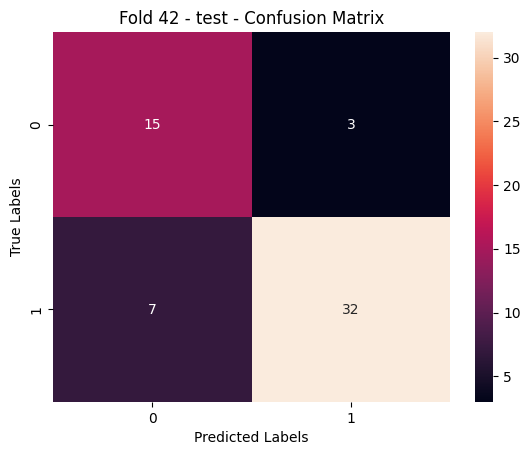

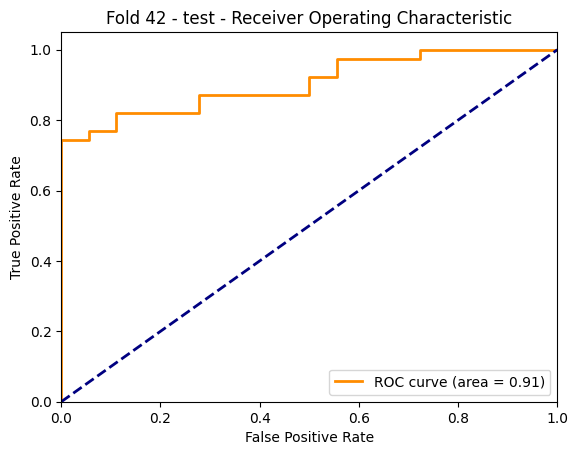

In [18]:

# Evaluate on test dataset
df_results_test = evaluate_predictions(trainer, test_dataset, test_subject_ids, fold_num, "test",80_1010)

In [19]:
model_num = 20250102
split = 80_1010
# Create an empty list to store the results DataFrames
all_results = []

# Evaluate on train dataset
# df_results_train = evaluate_predictions(trainer, train_dataset, train_subject_ids, fold_num, "train")
df_results_train['type']='train'
all_results.append(df_results_train)

# Evaluate on validation dataset
# df_results_val = evaluate_predictions(trainer, val_dataset, val_subject_ids, fold_num, "val")
df_results_val['type']='val'
all_results.append(df_results_val)

# Evaluate on test dataset
# df_results_test = evaluate_predictions(trainer, test_dataset, test_subject_ids, fold_num, "test")
df_results_test['type']='test'
all_results.append(df_results_test)

# Concatenate all results into a single DataFrame
df_all_results = pd.concat(all_results, ignore_index=True)
df_all_results['fold_num'] = fold_num
df_all_results['model_num'] = model_num

# Save the concatenated DataFrame to CSV
df_all_results.to_csv(f'./1004_20250102_Split{split}_fold{fold_num}_seed_model{model_num}_all_predictions.csv', index=False) # fold0_labelsplit_opt2_all_predictions.csv